# KUKA - Card Rectification
Perspective rectification and background croping for card type

### Reference
https://stackoverflow.com/questions/7263621/how-to-find-corners-on-a-image-using-opencv
https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv

#### History
- 23-05-2023
    - select quadrangle with criterion base on paper: Complex document classifiaction adn localization application on Identity document images

In [1]:
import sys
import os
import glob
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, 'd:/Project/kuka-py/')
runingPath=os.path.abspath("")
parentPath = Path(runingPath).resolve().parents[0]
if(sys.path[0]!=parentPath):
    sys.path.insert(0, parentPath)

from kukalib.cardcrop  import  *
print(getVersionInfo())

{'version': '0.3.1', 'date': datetime.date(2023, 5, 29)}


## Load image

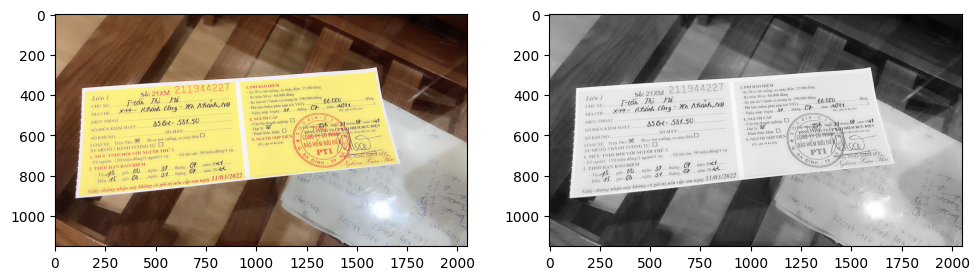

In [3]:

filename=r"D:\Google-drive-huy-work\imagedata\xemay\img35.jpg" #test item
filename=r"D:\Google-drive-huy-work\imagedata\xemay\img5.jpg" #test item
#filename=r"D:\Google-drive-huy-work\imagedata\xemay\img30.jpg" #test item
#filename = r"D:\Google-drive-huy-work\imagedata\perspective-skew\train\img_27.jpg"

src=cv2.imread(filename)

gray=cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(src,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(gray,cmap='gray')
plt.show()

## Step 1: try to extract background
### using Morph_Close to remove text

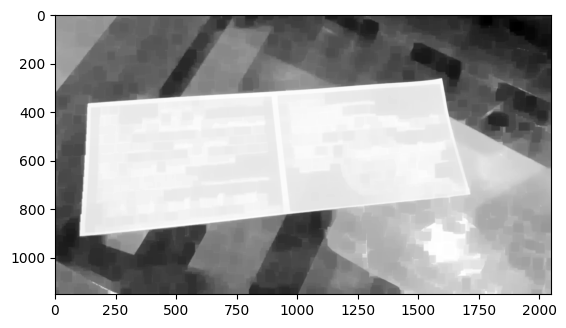

In [4]:
kernel=np.ones((7,7),np.uint8)
dilectImg=cv2.morphologyEx(src,cv2.MORPH_CLOSE,kernel,iterations=5)

gray=cv2.cvtColor(dilectImg,cv2.COLOR_BGR2GRAY)
    
blurImg=cv2.GaussianBlur(gray,(5,5),0)

plt.imshow(blurImg,cmap='gray')
plt.show()

## Step 2: edge and line detect

In [5]:
sobelImg=sobel(blurImg)
ret1,edgeImg = cv2.threshold(sobelImg,40,200, cv2.THRESH_OTSU + cv2.THRESH_TOZERO + cv2.THRESH_BINARY)

## make egde more dilect
edgeImg=cv2.morphologyEx(edgeImg,cv2.MORPH_DILATE,(2,2),iterations=2)

lines = cv2.HoughLinesP(edgeImg,rho=1,theta=1*np.pi/180,threshold=50,minLineLength=30,maxLineGap=10)


Num of line: 213


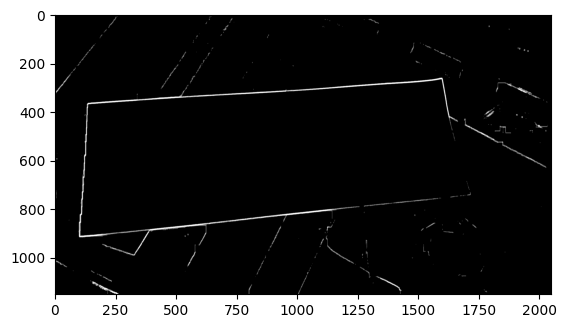

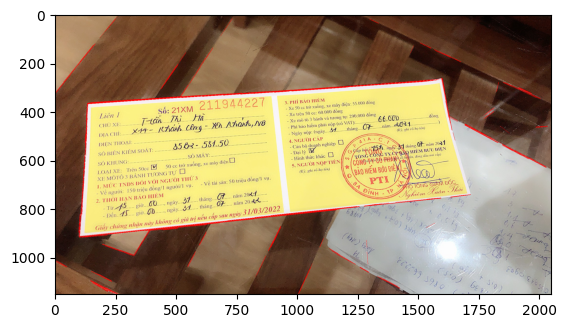

In [6]:
# print debug line
lineImg=src.copy()
print('Num of line:', len(lines))
for line in lines:
    x1=line[0][0]
    y1=line[0][1]
    x2=line[0][2]
    y2=line[0][3]
    cv2.line(lineImg,(x1,y1),(x2,y2),(0,0,255),1)

plt.imshow(edgeImg,cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.show()

## Step 3: trying to find quadrilateral by estimating 4 lines: top/bottom , left/right
    Asumption:
        - card is nearly center of image
        - 4 edges of card nearly present in the image
    

### version 1: select quadrangle based on the length of line

In [7]:
x=0
y=0
w=src.shape[1]
h=src.shape[0]

#assumpt: card is center of image and the skew angle is less than 45 degree
xcenter=w/2
ycenter=h/2

hLine=(x,y+h/2,x+w,y+h/2)
vLine=(x+w/2,y, x+w/2,y+h)

hLine=np.array(hLine).astype(np.int32)
vLine=np.array(vLine).astype(np.int32)

maxTLineLen=0
maxBLineLen=0
maxLLineLen=0
maxRLineLen=0
topline=[]
bottomline=[]
leftline=[]
rightline=[]
topleftPoint=[]
toprightPoint=[]
bottomleftPoint=[]
bottomrightPoint=[]

#Todo: refactor grouping line by using center point instead of angle
print("Total hough line",len(lines))
for line in lines:
    p1=line[0][0:2]
    p2=line[0][2:4]
    angle= getLineAngle(p1,p2)
    angle=abs(angle)

    length=getLineLength(p1,p2)
    if(angle<40): # top/bottom line
        if(p1[1]+p2[1])/2 < ycenter:
            if maxTLineLen<length:
                maxTLineLen=length
                topline=line[0]
        elif (p1[1]+p2[1])/2 > ycenter:
            if maxBLineLen<length:
                maxBLineLen=length
                bottomline=line[0]
    else:
        if (p1[0]+p2[0])/2 < xcenter:
            if maxLLineLen<length:
                maxLLineLen=length
                leftline=line[0]
        elif (p1[0]+p2[0])/2 > xcenter:
            if maxRLineLen<length:
                maxRLineLen=length
                rightline=line[0]

'draw line to debug image'
if len(topline)>0:
    cv2.line(lineImg,topline[0:2],topline[2:4],(255,0,0),5)
if len(bottomline)>0:
    cv2.line(lineImg,bottomline[0:2],bottomline[2:4],(255,0,0),5)
if len(leftline)>0:
    cv2.line(lineImg,leftline[0:2],leftline[2:4],(255,0,0),5)
if len(rightline)>0:
    cv2.line(lineImg,rightline[0:2],rightline[2:4],(255,0,0),5)

if(len(topline)>0 and len(bottomline)>0 and len(leftline)>0 and len(rightline)>0):
    print("selected line: top,bottom,left,right",topline,bottomline,leftline,rightline)
    # tính hệ số (a,b,c) của các đường thẳng
    aL,bL,cL=calcParams(leftline[0:2],leftline[2:4])
    aT,bT,cT=calcParams(topline[0:2],topline[2:4])

    aR,bR,cR=calcParams(rightline[0:2],rightline[2:4])
    aB,bB,cB=calcParams(bottomline[0:2],bottomline[2:4])

    # tìm các giao điểm tl,tr,bl,br
    topleftPoint=findIntersection((aL,bL,cL),(aT,bT,cT))
    toprightPoint=findIntersection((aR,bR,cR),(aT,bT,cT))
    bottomleftPoint=findIntersection((aL,bL,cL),(aB,bB,cB))
    bottomrightPoint=findIntersection((aR,bR,cR),(aB,bB,cB))

    # check if the polygon has four point
    corners=np.array([topleftPoint,toprightPoint,bottomrightPoint,bottomleftPoint])

    #corners = order_points(corners)
    
    destination_corners = find_dest(corners)
    
    width = getLineLength(topleftPoint,toprightPoint) + getLineLength(bottomleftPoint,bottomrightPoint)
    height = getLineLength(topleftPoint,bottomleftPoint)+ getLineLength(toprightPoint,bottomrightPoint)


    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    cropedImg = cv2.warpPerspective(src, M, (destination_corners[2][0], destination_corners[2][1]),
                                    flags=cv2.INTER_LINEAR)

    
    #show debug: middle vertical,hozirontal line of boundingbox
    x,y,w,h=cv2.boundingRect(np.float32(corners))
    w2=int(w/2)
    h2=int(h/2)
    
    cv2.line(lineImg,(x,y+h2),(x+w,y+h2),(0,0,255),5) #horizontal
    cv2.line(lineImg,(x+w2,y),(x+w2,y+h),(0,0,255),5) # vertical

    cv2.circle(lineImg,topleftPoint,3,(0,0,255),3)
    cv2.circle(lineImg,toprightPoint,3,(0,0,255),3)
    cv2.circle(lineImg,bottomleftPoint,3,(0,0,255),3)
    cv2.circle(lineImg,bottomrightPoint,3,(0,0,255),3)
    
    cv2.line(lineImg,topleftPoint,toprightPoint,(0,0,255),3)
    cv2.line(lineImg,toprightPoint,bottomrightPoint,(0,0,255),3)
    cv2.line(lineImg,bottomrightPoint,bottomleftPoint,(0,0,255),3)
    cv2.line(lineImg,bottomleftPoint,topleftPoint,(0,0,255),3)

Total hough line 213
selected line: top,bottom,left,right [ 521  344 1581  270] [ 100  914 1254  793] [ 99 915 133 428] [1594  263 1636  478]


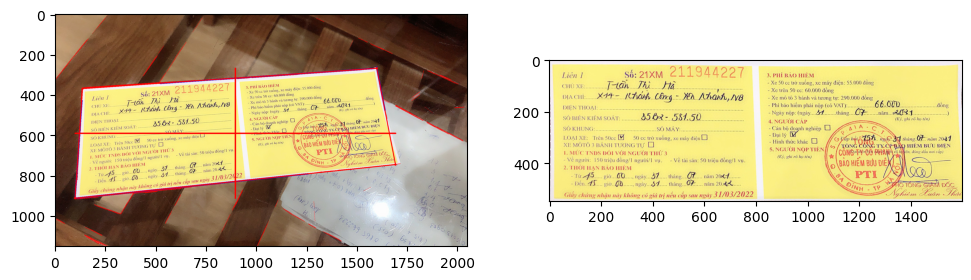

In [8]:
#show debug: middle vertical,hozirontal line of boundingbox
x,y,w,h=cv2.boundingRect(np.float32(corners))
w2=int(w/2)
h2=int(h/2)

cv2.line(lineImg,(x,y+h2),(x+w,y+h2),(0,0,255),5) #horizontal
cv2.line(lineImg,(x+w2,y),(x+w2,y+h),(0,0,255),5) # vertical

cv2.circle(lineImg,topleftPoint,3,(0,0,255),3)
cv2.circle(lineImg,toprightPoint,3,(0,0,255),3)
cv2.circle(lineImg,bottomleftPoint,3,(0,0,255),3)
cv2.circle(lineImg,bottomrightPoint,3,(0,0,255),3)

cv2.line(lineImg,topleftPoint,toprightPoint,(0,0,255),3)
cv2.line(lineImg,toprightPoint,bottomrightPoint,(0,0,255),3)
cv2.line(lineImg,bottomrightPoint,bottomleftPoint,(0,0,255),3)
cv2.line(lineImg,bottomleftPoint,topleftPoint,(0,0,255),3)


figSizeA4=(11.7,8.3)
plt.figure(figsize=figSizeA4)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
plt.show()



### version 2: select quadrangle based on criterion of angles of line

Topline: 62 - Bottomline:70 - Leftline:63 - RightLine:18
topline list: 1
Lines top: [[ 521.  344.]
 [1581.  270.]] bottom: [[ 100.  914.]
 [1254.  793.]] left: [[ 99. 915.]
 [133. 428.]] right[[1594.  263.]
 [1636.  478.]]
Angle A:82.01	B:82.94	C:84.93	D:80.02
Meet criterion 1: True
	Line angle of Top 3.99 - bottom 5.99  - left: 86.01 - right: 78.95 
Meet criterion 2: True
Meet criterion 3: True


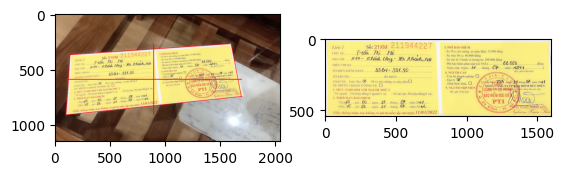

Lines top: [[ 521  344]
 [1581  270]] bottom: [[ 100  914]
 [1254  793]] left: [[ 99 915]
 [133 428]] right[[1594  263]
 [1636  478]]
Angle A:82.01	B:82.94	C:84.93	D:80.02
Meet criterion 1: True
	Line angle of Top 3.00 - bottom 5.00  - left: 86.00 - right: 78.00 
Meet criterion 2: True
Meet criterion 3: True


In [9]:
x=0
y=0
w=src.shape[1]
h=src.shape[0]

#assumpt: card is center of image and the skew angle is less than 45 degree
xcenter=w/2
ycenter=h/2

hLine=(x,y+h/2,x+w,y+h/2)
vLine=(x+w/2,y, x+w/2,y+h)

hLine=np.array(hLine).astype(np.int32)
vLine=np.array(vLine).astype(np.int32)


topleftPoint=[]
toprightPoint=[]
bottomleftPoint=[]
bottomrightPoint=[]

toplineList=[]
bottomlineList=[]
leftlineList=[]
rightlineList=[]
selectedQuadrangleList=[]

# grouping lines in top,bottom,left,right
# then create line list in form [x1,y1,x2,y2,len,angle]
for line in lines:
    p1=line[0][0:2]
    p2=line[0][2:4]
    angle= getLineAngle(p1,p2)
    linelength=getLineLength(p1,p2)
    angle=abs(angle)
    lineExtend=np.append(line[0],[round(linelength),angle])
    if(angle<40): # top/bottom line
        if(p1[1]+p2[1])/2 < ycenter:
            toplineList.append(lineExtend)
        elif (p1[1]+p2[1])/2 > ycenter:
            bottomlineList.append(lineExtend)
    else:
        if (p1[0]+p2[0])/2 < xcenter:
            leftlineList.append(lineExtend)
        elif (p1[0]+p2[0])/2 > xcenter:
            rightlineList.append(lineExtend)

print("Topline: {} - Bottomline:{} - Leftline:{} - RightLine:{}".format(len(toplineList),len(bottomlineList),len(leftlineList),len(rightlineList)))

# converting list(object) to ndarray then sorting length by descending
toplineList = np.vstack(toplineList)
bottomlineList = np.vstack(bottomlineList)
leftlineList= np.vstack(leftlineList)
rightlineList = np.vstack(rightlineList)

#select top line =5
toplineList = toplineList[toplineList[:,4].argsort()[::-1]][:1]
bottomlineList = bottomlineList[bottomlineList[:,4].argsort()[::-1]][:1]
leftlineList = leftlineList[leftlineList[:,4].argsort()[::-1]][:1]
rightlineList = rightlineList[rightlineList[:,4].argsort()[::-1]][:1]

print("topline list:",len(toplineList))
#sorting by x,y to get largest rectangular
# toplineList = toplineList[toplineList[:,1].argsort()] # min y
# bottomlineList = bottomlineList[bottomlineList[:,1].argsort()[::-1]] # maxy
# leftlineList = leftlineList[leftlineList[:,0].argsort()] #min x
# rightlineList = rightlineList[rightlineList[:,0].argsort()[::-1]] #max x


stopSearching = False
top=100
count=0
debug=True
countDebug=0
for topline in toplineList:
    if stopSearching: 
        break
    for bottomline in bottomlineList:
        if stopSearching:
            break
        for leftline in leftlineList:
            if stopSearching:
                break
            for rightline in rightlineList:
                countDebug +=1
                debug = countDebug<=5
                criterionResult,checkResult = verifyQuadrilateral(topline,bottomline,leftline,rightline,debug)
                if(checkResult):
                    selectedQuadrangleList.append([topline,bottomline,leftline,rightline])
                    stopSearching = checkResult
                if stopSearching:
                    break
if(len(selectedQuadrangleList)==0):
    print("No quadrangle found")

for q in selectedQuadrangleList:
    topline=q[0].astype(int)
    bottomline=q[1].astype(int)
    leftline=q[2].astype(int)
    rightline=q[3].astype(int)
    cropedImg,lineImg,_ = cropImage(src,topline[0:4],bottomline[0:4],leftline[0:4],rightline[0:4])
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
    plt.show()
    verifyQuadrilateral(topline,bottomline,leftline,rightline,True)


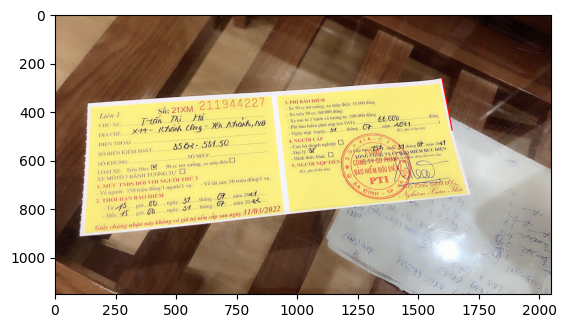

False
True
True
False
False
False
True
True


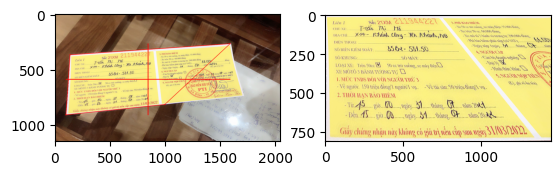

In [10]:
# debug online
#[ 521  344 1581  270] [ 100  914 1254  793] [ 99 915 133 428] [1594  263 1636  478]
#[ 521  344 1581  270] [ 100  914 1254  793] [ 99 915 133 428] [1594  263 1636  478]
topline=np.asarray([[521,344],[1581,270]])
bottomline=np.asarray([[100,914], [1254,793]] )
leftline=np.asarray( [[99,915], [ 133, 428]] )
rightline =np.asarray( [[1594,263], [1363,478]])

debugImg = src.copy()

# cv2.line(debugImg,topline[0],topline[1],(0,0,255),3)
# cv2.line(debugImg,bottomline[0],bottomline[1],(0,0,255),3)
# cv2.line(debugImg,leftline[0],leftline[1],(0,0,255),3)
cv2.line(debugImg,(1594 , 263),(1636 , 478),(0,0,255),3)
plt.imshow(cv2.cvtColor(debugImg,cv2.COLOR_BGR2RGB))
plt.show()

print(not isPoinOnLeft(topline,leftline[0]) or not isPoinOnLeft(topline,leftline[1]))
print(not isPoinOnLeft(topline,rightline[0]) or not isPoinOnLeft(topline,rightline[1]))
# is quadrangle if leftline and rightline is above bottomline
print(isPoinOnLeft(bottomline,leftline[0]) or isPoinOnLeft(bottomline,leftline[1]))
print(isPoinOnLeft(bottomline,rightline[0]) or isPoinOnLeft(bottomline,rightline[1]))

# is quadrangle if topline/bottomline not on the left of leftline
print(not isPoinOnLeft(leftline,topline[0]) or not isPoinOnLeft(leftline,topline[1]))
print(not isPoinOnLeft(leftline,bottomline[0]) or not isPoinOnLeft(leftline,bottomline[1]))
# is quadrangle if topline/bottomline left of rightline
print( isPoinOnLeft(rightline,topline[0]) or  isPoinOnLeft(rightline,topline[1]))
print ( isPoinOnLeft(rightline,bottomline[0]) or  isPoinOnLeft(rightline,bottomline[1]))

cropedImg,lineImg,_ = cropImage(src,np.squeeze(topline.reshape(1,4)),np.squeeze(bottomline.reshape(1,4)),np.squeeze(leftline.reshape(1,4)),np.squeeze(rightline.reshape(1,4)))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(lineImg,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cropedImg,cv2.COLOR_BGR2RGB))
plt.show()   
